<a id="title_ID"></a>
# Plotting Images from Kepler Target Pixel Files
<br>
This notebook tutorial demonstrates the loading and extracting of information from Kepler Target Pixel Files to plot images that show the pixels used to create data found in Kepler light curve files. 
<br>
<img style="float: right;" src="./tpf_fluxplot_28-29.png" alt="tpf_fluxplot_28-29" width="350"/>
<img style="float: right;" src="./tpf_fluxplot0.png" alt="tpf_fluxplot0" width="350"/>
### Table of Contents
<div style="text-align: left"> <br> [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Getting the Data](#data_ID) <br> [Reading FITS Extensions](#extension_ID) <br> [Plotting the Images](#images_ID) <br> [The Aperture Extension](#aperture_ID) <br> [Additional Resources](#resources_ID) <br> [About this Notebook](#about_ID) </div>

***

<a id="intro_ID"></a>
## Introduction
**Target Pixel File background:**
The pixels used to create data in the light curve files are contained within a predefined mask. Each target pixel file packages these pixels as a time series of images in a binary FITS table. These files can then be used to perform photometry on. The binary table in a Target Pixel File (TPF) holds columns of data that contain an array in each cell. 

**Some notes about the file:** kplr008957091-2012277125453_lpd-targ.fits.gz
<br>The filename contains phrases for identification, where
 - kplr = Kepler 
 - 008957091 = Kepler ID number
 - 2012277125453 = year 2012, day 277, time 12:54:53
 - lpd-targ = long cadence target pixel file

**Defining some terms:**
 - **Cadence:** the frequency with which summed data are read out. Files are either short cadence (a 1 minute sum) or long cadence (a 30 minute sum). The data we are using here is a long cadence file. 
 - **HDU:** Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension.  

For more information about the Kepler mission and collected data, visit the [Kepler archive page](https://archive.stsci.edu/kepler/). To read more details about Target Pixel Files and relevant data terms, look in the [Kepler archive manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=22).

[Top of Page](#title_ID)

***

<a id="imports_ID"></a>
## Imports
Let's start by importing some libraries to the environment: 
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

[Top of Page](#title_ID)

***

<a id="data_ID"></a>
## Getting the Data
Start by importing libraries from Astroquery. For a longer, more detailed description using of Astroquery, please visit this [tutorial](https://github.com/spacetelescope/MAST-API-Notebooks/blob/master/MUG2018_APITutorial_Astroquery.ipynb) or read the Astroquery [documentation](https://astroquery.readthedocs.io/en/latest/#). 

In [2]:
from astroquery.mast import Mast
from astroquery.mast import Observations

<br>Next, we need to find the data file. This is similar to searching for the data using the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) in that we will be using certain keywords to find the file. The object we are looking for is kplr008957091, collected by the Kepler spacecraft. We are also looking for a long cadence timeseries file.

In [3]:
keplerObs = Observations.query_criteria(target_name='kplr008957091', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[0])
yourProd = Observations.filter_products(keplerProds,extension='kplr008957091-2012277125453_lpd-targ.fits.gz',
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights
str10,str6,str10,str36,str59,str1,str110,str7,str28,str1,str1,str6,str1,str7,str44,int64,str10,str6
9000159893,Kepler,timeseries,kplr008957091_lc_Q000000000011111111,Target Pixel Long Cadence (TPL) - Q14,C,mast:Kepler/url/missions/kepler/target_pixel_files/0089/008957091/kplr008957091-2012277125453_lpd-targ.fits.gz,SCIENCE,--,--,--,Kepler,--,GO30032,kplr008957091-2012277125453_lpd-targ.fits.gz,4365449,9000159893,PUBLIC


<br>Now that we've found the data file, we can download it using the reults shown in the table above:

In [4]:
Observations.download_products(yourProd, mrp_only=False, cache=False)

 [Done]


Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz,COMPLETE,None,None


[Top of Page](#title_ID)

***

<a id="extension_ID"></a>
## Reading FITS Extensions
<br>Now that we have the file, we can start working with the data. We will begin by assigning a shorter name to the file to make it easier to use. Then, using the info function from astropy.io.fits, we can see some information about the FITS Header Data Units:

In [5]:
filename = "./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  TARGETTABLES    1 BinTableHDU    287   4757R x 13C   [D, E, J, 64J, 64E, 64E, 64E, 64E, 64E, J, E, E, 40E]   
  2  APERTURE      1 ImageHDU        48   (8, 8)   int32   


- **No. 0 (Primary): **
<br>This HDU contains meta-data related to the entire file.
- **No. 1 (Targettables): **
<br>This HDU contains a binary table that has 13 columns containing a series of either scalar values or images. We will be taking some of the images from the table and plotting them in this tutorial.
- **No. 2 (Aperture): **
<br>This HDU contains the image extension with data collected from the aperture. We will also use this to display a bitmask plot that visually represents the optimal aperture used to create the SAP_FLUX column in the light curve data.

For more detailed information about header extensions, look [here](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=22).

<br>Let's say we wanted to see more information about the extensions than what the fits.info command gave us. For example, we can access information stored in the header of the Binary Table extension (No.1, TARGETTABLES). The following line opens the FITS file, writes the first HDU extension into header1, and then closes the file. Only 24 columns are displayed here but you can view them all by adjusting the range:

In [6]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[1:25])) #repr() prints the info into neat columns

BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1724 / length of first array dimension                
NAXIS2  =                 4757 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   13 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'           / column title: barycenter - timeslice correction
TFORM2  = 'E       '        

<br> We can also view a table of the data from the Binary Table extension. This is where we can find the flux and time columns to be plotted later. Here only the first four rows of the table are displayed:

In [7]:
with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytab = Table(binaryext)
binarytab[0:4]

TIME,TIMECORR,CADENCENO,"RAW_CNTS [8,8]","FLUX [8,8]","FLUX_ERR [8,8]","FLUX_BKG [8,8]","FLUX_BKG_ERR [8,8]","COSMIC_RAYS [8,8]",QUALITY,POS_CORR1,POS_CORR2,"RB_LEVEL [8,5]"
float64,float32,int32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32
1274.1395732864694,0.0022160665,57024,422568 .. 421938,41.62306 .. 0.49973154,1.0728891 .. 1.077012,166.55408 .. 166.43286,0.05004611 .. 0.05002594,nan .. nan,0,0.018315108,-0.052525554,0.16289888 .. 0.22096205
1274.1600076621398,0.0022167421,57025,422568 .. 421938,41.12269 .. 0.40782627,1.0728829 .. 1.0770054,166.5374 .. 166.41513,0.05014606 .. 0.050128847,nan .. nan,0,0.018484294,-0.052207224,0.19264737 .. 0.28943384
1274.1804419378168,0.0022174178,57026,422598 .. 421938,43.76557 .. 0.18402159,1.0735049 .. 1.0770029,166.44955 .. 166.32483,0.05003051 .. 0.05001035,nan .. nan,0,0.019123403,-0.052663438,0.27529782 .. 0.28463778
1274.2008761132602,0.0022180933,57027,422588 .. 421938,42.315395 .. 0.26509726,1.073293 .. 1.076999,166.54523 .. 166.4112,0.05008907 .. 0.05007079,nan .. nan,0,0.018382369,-0.052379206,0.2684216 .. 0.297417


<br>Some of the columns (RAW_CNTS through COSMIC_RAYS) are 8x8 arrays. These are the pixels used for light curve data packaged as images into the Binary Table. Each of these arrays is an image taken at a certain time as seen in the TIME column. To find out how many times there are, we can run the following code to get the vertical length of the entire table:

In [8]:
print(len(binarytab['TIME']))

4757


[Top of Page](#title_ID)

***

<a id="images_ID"></a>
## Plotting the Images
To better understand the arrays in the table, we can single out one cell and display its data. For example, let's read the cell in Row 0, column FLUX. This is the flux data collected at time 1274.1395732864694.

In [9]:
binarytab['FLUX'][0]

array([[ 4.1623058e+01,  1.7780533e+01,  3.1153817e+00, -3.0876877e+00,
         8.3767604e-03, -1.0850269e+00, -8.1516063e-01, -2.5957384e+00],
       [ 3.0861683e+01,  1.0227163e+01,  5.5491271e+00,  7.6004462e+00,
         3.4271725e+01,  6.9740272e+00,  1.0782831e+00,  7.1954594e+00],
       [-1.4854238e+00,  5.4094785e-01,  3.5754349e+00,  1.8321907e+01,
         5.8315243e+01,  1.7005610e+01,  1.4785897e+00,  2.1474166e-01],
       [-2.9369431e+00, -3.0120549e-01,  1.9583700e+01,  1.2907016e+02,
         2.6917322e+02,  7.8723610e+01,  1.8297552e+01,  6.7504066e+01],
       [-5.1648269e+00,  6.6967867e-02,  2.4730293e+01,  1.8597522e+02,
         3.9219736e+02,  9.2981400e+01,  1.8644941e+01,  1.4952176e+02],
       [ 2.4195774e-01, -2.2746756e+00, -7.2001988e-01,  6.1791143e+00,
         1.6116604e+01,  1.0269024e+01,  3.5868566e+00,  1.2844697e+00],
       [ 2.1793385e+00, -2.0849459e+00, -2.2841897e+00, -2.2008568e-01,
         5.5619407e+00,  1.3116534e+01,  1.8261925e+00, -2

<br>
<br>We can then plot this array as an image, where each pixel is shown as a color value from the above array:

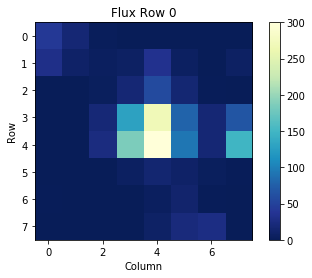

In [10]:
plt.title('Flux Row 0')
plt.xlabel('Column')
plt.ylabel('Row')

plt.imshow(binarytab['FLUX'][0], cmap=plt.cm.YlGnBu_r)
plt.colorbar()
plt.clim(0,300)

<br>This plot can be made for any of the arrays in the table. To read in and plot a different cell, change the row number from [0] to another number. 

<br>Some arrays contain no numbers, only NaN values. This results in completely blank image frames:

In [11]:
binarytab['FLUX'][34]

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

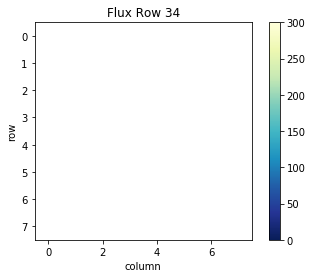

In [12]:
plt.title('Flux Row 34')
plt.xlabel('column')
plt.ylabel('row')

plt.imshow(binarytab['FLUX'][34], cmap=plt.cm.YlGnBu_r)
plt.colorbar()
plt.clim(0,300)

<br>We can also view the difference between one frame and another. For example, if we want to see the change from the flux at time in row 20 subtracted from the flux at time in row 19, we can write the following:

In [13]:
arr = np.subtract(binarytab['FLUX'][28], binarytab['FLUX'][29])
print(arr)

[[-0.10368347  1.2084408   0.7001476  -0.04124689 -1.0750767  -0.13303757
   1.1955365  -0.308725  ]
 [-0.8178196   3.288806   -0.01144838  4.190505    1.0418396  -0.12780714
  -1.6264764   0.39404774]
 [-0.80597305  1.1767769  -2.1247475   2.0623436   1.0380287  -2.25745
  -0.9374518  -1.7162728 ]
 [-0.8251231  -0.22384816 -0.72644997 -0.04460144  3.20755     0.5736923
   1.1855717   1.1150208 ]
 [-0.10608602  1.8990426  -0.7197819   1.3527222  -1.2155457  -0.84685516
  -0.22213173 -2.4338684 ]
 [ 1.3052053   0.488378   -1.4316924   1.3895159   1.0554571   2.7365294
  -0.21660066  1.1082048 ]
 [-2.248003   -2.3650186  -2.852107    4.1624756   1.0340705  -0.8345432
   0.48870218 -1.7171237 ]
 [-0.10844719 -1.6385655  -0.7226268  -1.4699272   1.7503319  -1.532999
   1.8900471   1.1174535 ]]


We can then plot this array as well:

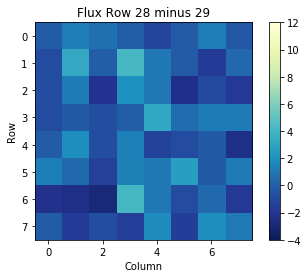

In [14]:
plt.title('Flux Row 28 minus 29')
plt.xlabel('Column')
plt.ylabel('Row')

plt.imshow(arr, cmap=plt.cm.YlGnBu_r)
plt.colorbar()
plt.clim(-4, 12)

[Top of Page](#title_ID)

***

<a id="aperture_ID"></a>
## The Aperture Extension
We can also make a plot of the third header extension; the image extension. This data is stored as an array of integers that encodes which pixels were collected from the spacecraft and which were used in the optimal aperture (look here for more information on the [aperture extension](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=24)). 
<br> 
<br>First, we need to re-open the FITS file and access the header. Next, we read the the image extension (No. 2, APERTURE) and print it as an array:

In [15]:
with fits.open(filename) as hdulist: 
    imgdata = hdulist[2].data
    
print(imgdata)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 3 1 1 1]
 [1 1 1 1 3 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


<br>We can then plot the above array, which will show the pixels used in the optimal aperture for photometry:

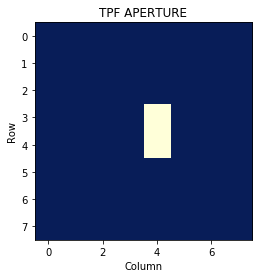

In [16]:
plt.figure()
plt.title('TPF APERTURE')
plt.xlabel('Column')
plt.ylabel('Row')
plt.imshow(imgdata, cmap=plt.cm.YlGnBu_r)

[Top of Page](#title_ID)

***

<a id="resources_ID"></a>
## Aditional Resources
For more information about the MAST archive and details about mission data:
<br>
<br>[MAST API](https://mast.stsci.edu/api/v0/index.html)
<br>[Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
<br>[Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
<br>[Exo.MAST website](https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html)

***

<a id="about_ID"></a>
## About this Notebook
**Author:** Josie Bunnell, STScI SASP Intern
<br>**Updated On:** 08/10/2018

***

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 